# Ray et al 2013 Exploratory Data Analysis
**Authorship:**
Adam Klie, *08/27/2022*
***
**Description:**
Notebook to perform a brief exploratory data analysis (EDA) on the Ray et al (2013) dataset.
***

In [12]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
# General imports
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# EUGENe imports
import eugene as eu
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/"

# EUGENe packages
import seqdatasets
import seqdata as sd

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Eugene version: {eu.__version__}")
#print(f"SeqDatasets version: {seqdatasets.__version__}")
#print(f"SeqData version: {sd.__version__}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Xarray version: 2023.4.0
Eugene version: 0.0.8


# Download and load in the dataset to a raw `SeqData` object

In [9]:
# For now hack to get things working until I can sort out SeqData error
sdataframe = pd.read_csv("/cellar/users/aklie/data/eugene/revision/ray13/norm_data.txt.gz", na_values=" NaN", sep="\t", low_memory=False)
#sdata = xr.Dataset.from_dataframe(sdataframe)
#sdata = sdata.rename_dims({"index": "_sequence"})

In [11]:
sdataframe["RNCMPT00001"]

0        -0.975763
1        -0.766150
2         2.291724
3        -0.490199
4         0.203296
            ...   
241352    8.792648
241353    0.376320
241354   -0.490977
241355    2.455112
241356    0.426749
Name: RNCMPT00001, Length: 241357, dtype: float64

In [7]:
sdataframe["RNCMPT00001"].values

KeyError: 'RNCMPT00001'

In [ ]:
sdataframe[target_cols] = sdataframe[target_cols].astype(float)

In [102]:
# Necessary step right now but don't want it to be in future
sdata[target_cols] = sdata[target_cols].astype(float)

In [41]:
# Load in the downloaded dataset from the RNAcomplete supplementary website and double check that the index and names loaded in correctly
sdata = seqdatasets.ray13(batch_size=10000)

Dataset ray13 norm_data.txt.gz has already been downloaded.


241357it [02:23, 1684.40it/s]


In [42]:
sdata

<xarray.Dataset>
Dimensions:      (_sequence: 241357)
Dimensions without coordinates: _sequence
Data variables: (12/247)
    Probe_ID     (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>
    Probe_Set    (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00001  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00002  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00003  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00004  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...           ...
    RNCMPT00285  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00287  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00288  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00289  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00291  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    seq          (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>

In [94]:
# Pull out the columns from seqs_annot to be used as targets (based on motif ID)
column_keys = pd.Index(sdata.data_vars.keys())
target_mask = column_keys.str.contains("RNCMPT")
target_cols = column_keys[target_mask]
len(target_cols)

244

In [5]:
sdata[target_cols] = sdata[target_cols].astype(float)

# Sequence information

In [6]:
# Grab sequence lengths and plot distribution
sdata["seq_len"] = xr.DataArray([len(seq) for seq in sdata["RNA_Seq"].values], dims="_sequence")
pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)
plt.show()

NameError: name 'pl' is not defined

# Target information

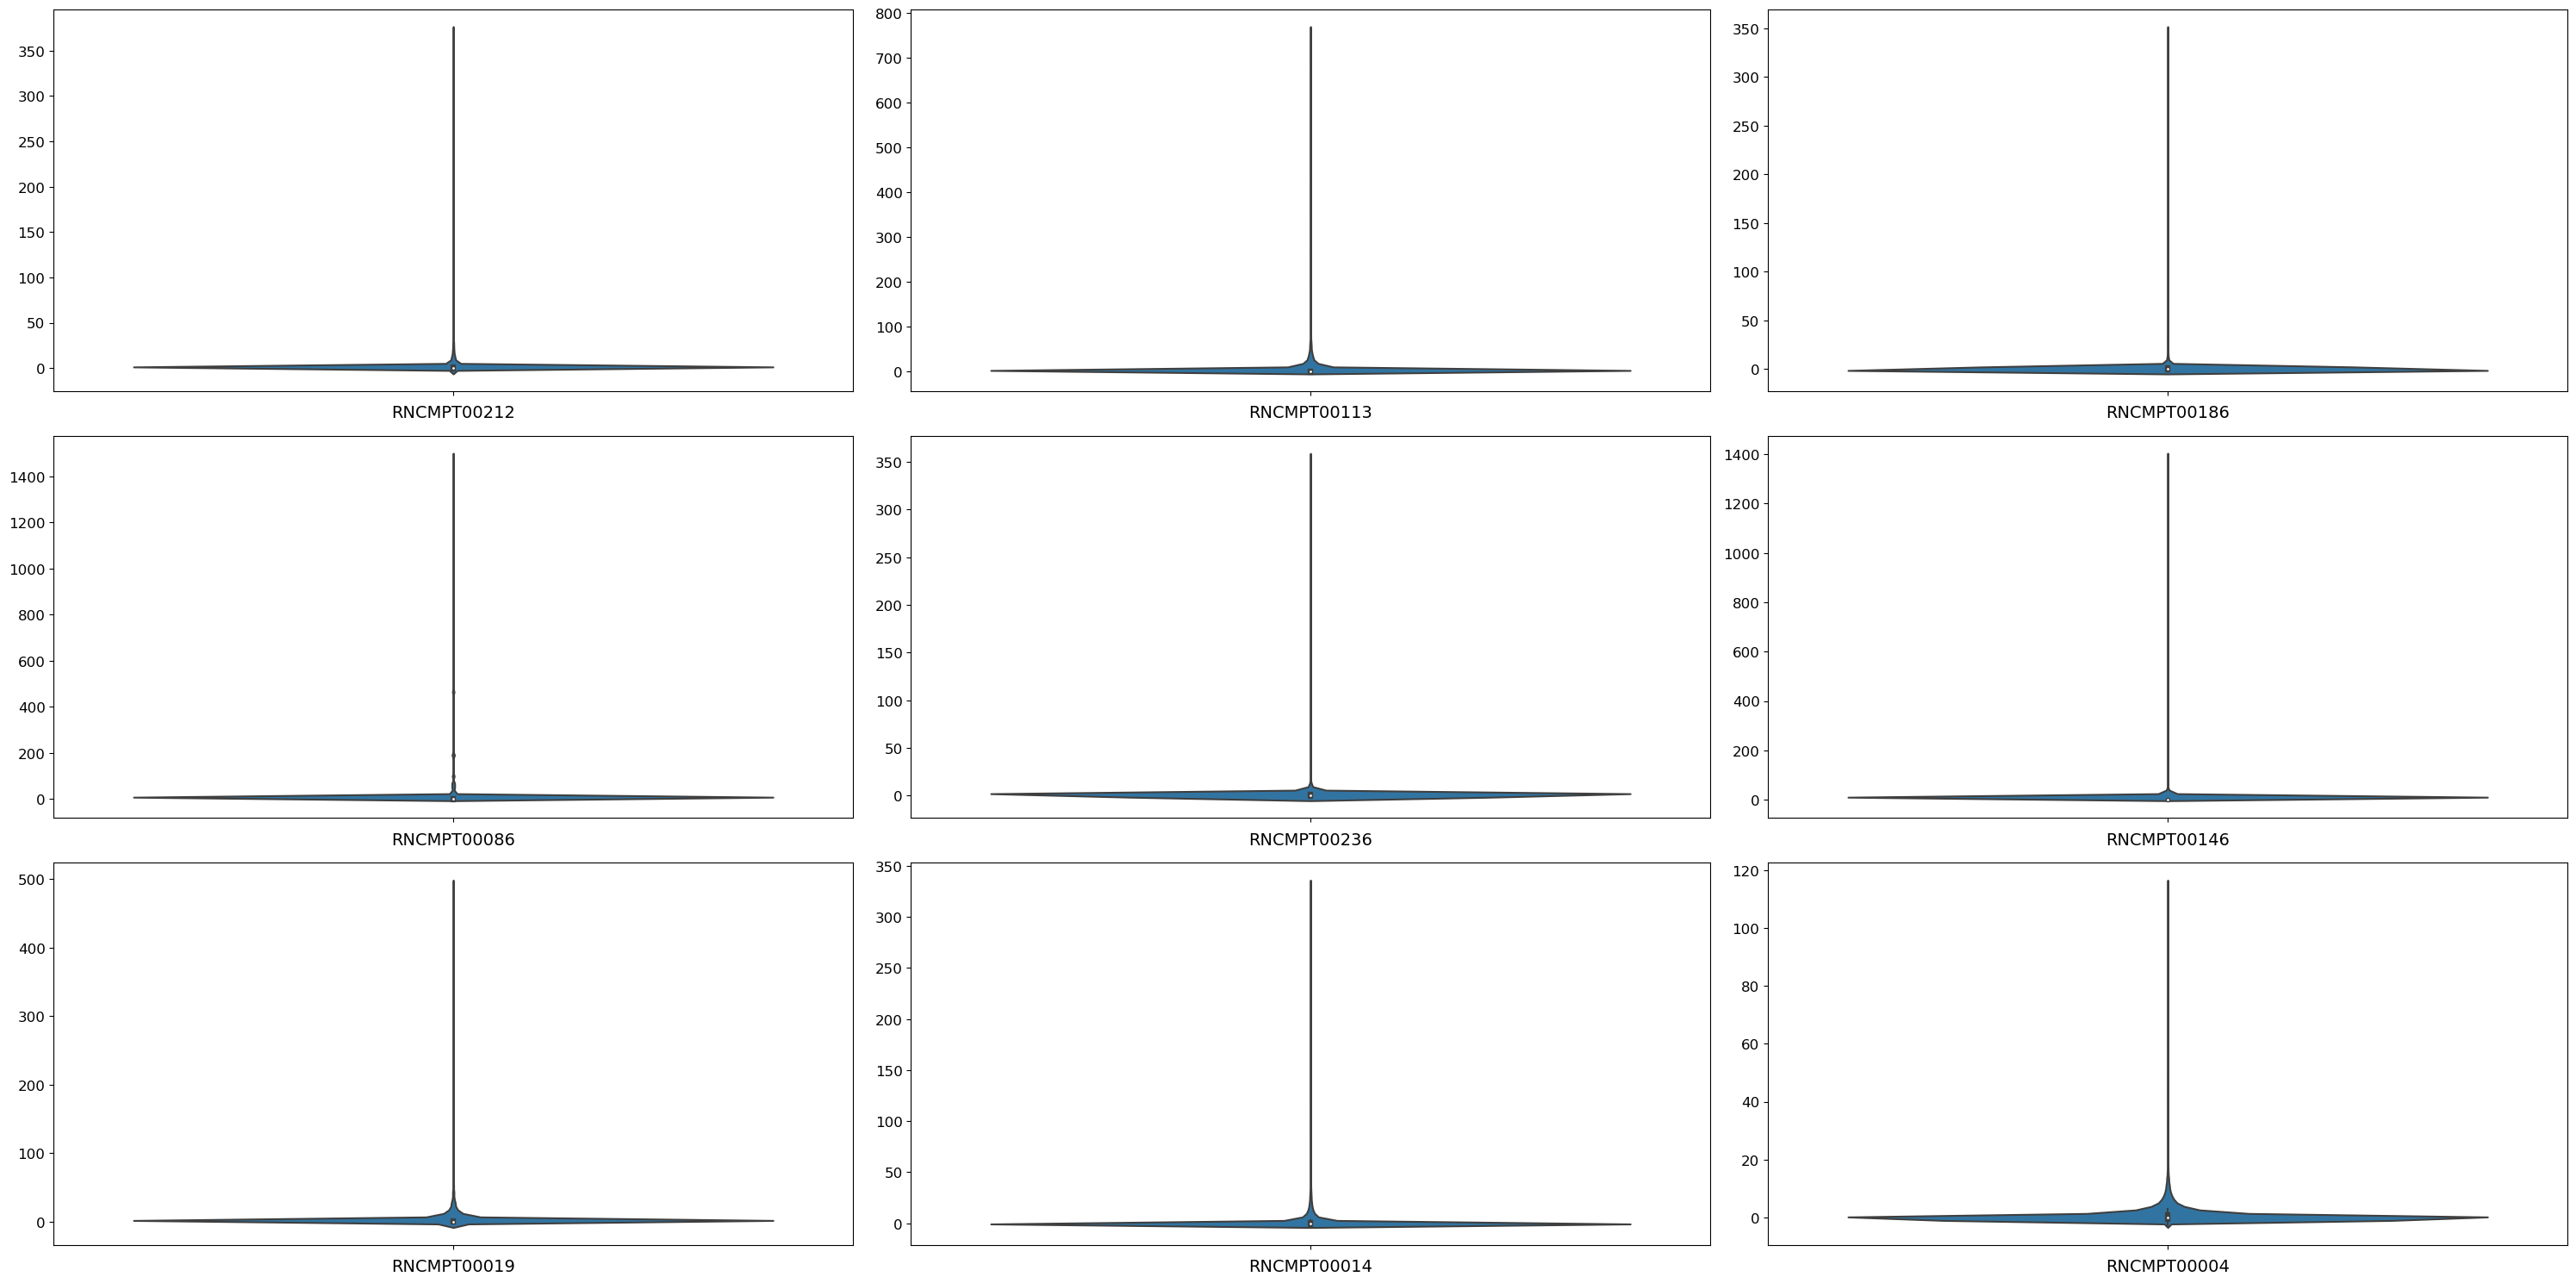

In [ ]:
# Lets take a look at the distributions of a few randomly selected RBPs across all probes
pl.violinplot(
    sdata, 
    keys=list(np.random.choice(target_cols, 9))
)
plt.show()

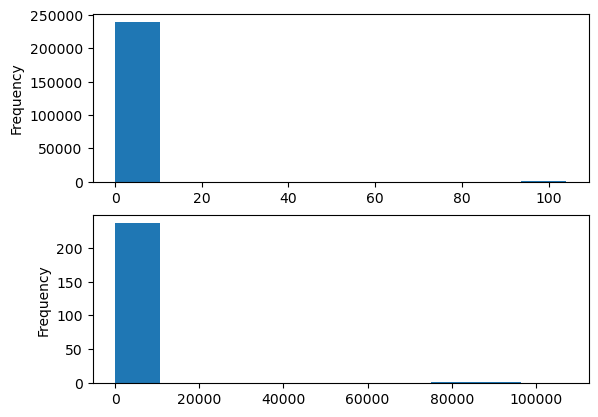

In [ ]:
# Plot the number NaN values across target columns and across sequences
fig, ax = plt.subplots(nrows=2, ncols=1)
sdata[target_cols].to_dataframe().isna().sum(axis=1).plot(kind="hist", ax=ax[0])
sdata[target_cols].to_dataframe().isna().sum(axis=0).plot(kind="hist", ax=ax[1])
plt.show()

In [ ]:
# Determine the number of targets that would be included in the dataset if we dropped those with > 1% NaN values
nan_percents = sdata[target_cols].to_dataframe().isna().sum(axis=0).sort_values(ascending=False)/sdata.dims["_sequence"]
cleaned_annot = sdata[target_cols].to_dataframe().drop(nan_percents[nan_percents > 0.01].index, axis=1)
cleaned_cols = target_cols.drop(nan_percents[nan_percents > 0.01].index)
cleaned_annot.head()

,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,RNCMPT00109,...,RNCMPT00088,RNCMPT00089,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00099,index
_sequence,,,,,,,,,,,,,,,,,,,,,
0,1.122218,1.272641,-1.089717,-0.067146,0.831671,-0.070631,2.779642,2.509418,1.811186,2.762714,...,7.101329,1.186928,0.907487,1.282393,0.861743,-0.115417,0.126413,1.010198,-0.060651,0
1,8.840295,-2.113002,2.397376,-1.809082,-0.963712,-0.202229,-0.121975,-0.038112,-0.636935,-1.100769,...,-0.250032,0.168827,0.029810,0.986617,3.979510,-0.388808,-0.348266,0.216500,3.820988,1
2,-0.353194,-0.183539,-0.467021,-1.865032,0.663077,0.626212,0.910989,1.431777,0.003613,-0.086335,...,-0.852603,-0.688271,1.821554,1.289043,-1.282063,-0.640817,0.054688,-1.351889,-0.057985,2
3,1.386679,-0.236797,-0.031135,-0.997679,-0.079547,0.473447,6.296981,7.877085,13.880688,10.165925,...,6.800043,1.198766,1.121754,1.009484,0.450070,-1.106999,1.617407,0.272935,0.643033,3
4,-0.267395,1.387100,0.986554,-0.622790,-0.261790,-0.782576,-0.674672,-0.432181,0.007804,-0.629471,...,0.190654,2.725847,0.472460,0.476233,-0.150370,-0.545728,-0.398383,-0.677650,-0.891034,4


In [ ]:
# Determine how many sequences would be included in the dataset if we dropped those with any NaN values
len(np.where(cleaned_annot[cleaned_cols].isna().sum(axis=1) == 0)[0])

221796

# DONE!

---

# Scratch

In [ ]:
# Currently fails
sdata = sd.read_table(
    name="seq",
    tables="/cellar/users/aklie/data/eugene/revision/ray13/norm_data.txt.gz",
    out="/cellar/users/aklie/data/eugene/revision/ray13/ray13_norm.zarr",
    seq_col="RNA_Seq",
    fixed_length=False,
    batch_size=1000,
    overwrite=True
)